## **Catégorisez automatiquement des questions**

### partie 4/8 (suite): Prédiction de tags, approche supervisée, sentence embedding

#### <br> L'objectif de ce notebook est de découvrir des techniques NLP plus avancées: Word2Vec (peut être remplacé par Doc2Vec), BERT, USE

<br>


## 1 Imports


### 1.1 Librairies


In [351]:
#
import os
import ast
from pprint import pprint
import time

import gdown
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from gensim.models.keyedvectors import KeyedVectors
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.multioutput import MultiOutputClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import operator
from datasets import load_dataset

import transformers
from transformers import AutoTokenizer
from transformers import pipeline
from transformers import TFAutoModelForQuestionAnswering


### Fonctions


In [352]:
def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)
    df['all_tags'] = df['all_tags'].apply(ast.literal_eval)


df_freq = pd.DataFrame()

def keep_most_frequent_tags(list_tags, df_freq=df_freq, lim=100):
    """
    Keep only the n most frequent tags (default 100).

    Parameters:
    - liste_tokens (list): The input list of tokens to be processed.
    - forbidden_list (set): A set of forbidden tokens, which includes stop words,
      tokens exceeding upper frequency limits, and tokens falling below lower frequency limits.

    Returns:
    list: A filtered list of tokens that excludes stop words, tokens exceeding upper frequency limits,
    and tokens falling below lower frequency limits.
    """

    mandatory_list = df_freq['Tag'][:lim].tolist()
    filtered_list = [token for token in list_tags if token in mandatory_list]

    return filtered_list


def create_top_n_tags_feature(data, n=100, slice=1, df_freq=df_freq):
    data[f'top_tags_{n}'] = data['all_tags'].apply(
        lambda x: keep_most_frequent_tags(x, df_freq=df_freq, lim=n)
    )

    data = data.loc[data[f'top_tags_{n}'].apply(len) >= 0, :].copy()
    print(data.shape, '\n')

    slice_df = data[::slice]
    # slice_df.reset_index(drop=True, inplace=True)

    # stratify ?
    train_df, test_df = train_test_split(slice_df, test_size=0.1, random_state=42)

    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)


    return train_df, test_df



### Data


In [353]:
raw_data = pd.read_csv('./../0_data/cleaned_data/bow_classic.csv', sep=',')

turn_str_back_into_list(raw_data)

display(raw_data.tail())

print(raw_data.shape)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
47660,2011-05-23 22:22:56,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,"[c#, winforms, pdf, .net-4.0, printing]","[send, file, document, printer, print]","[send, file, document, printer, print, premise...","[send, file, document, printer, print]","[premise, user, click, file, spit, desktop, wa..."
47661,2011-05-23 21:15:51,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...","[visual-studio, visual-studio-2010, dll, style...","[mark, dll, error, message, vs2010]","[mark, dll, error, message, vs2010, run, get, ...","[error, message]","[run, error, message, need, mark, dll, set, dl..."
47662,2011-05-23 21:05:59,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...","[c++, algorithm, file, directory, file-rename]","[change, text, file, name, c]","[change, text, file, name, c, like, change, tx...","[change, text, file]","[like, change, txt, file, find, example, want,..."
47663,2011-05-23 20:06:35,php implode (101) with quotes,Imploding a simple array \nwould look like th...,"[php, arrays, string, csv, implode]","[php, quote]","[php, quote, array, look, array, array, lastna...",[quote],"[implode, array, look, array, email, phone, ar..."
47664,2011-05-23 20:00:57,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,"[ios, file, filenames, character-encoding, nsf...","[character, allow, file, name]","[character, allow, file, name, look, way, make...","[character, allow, file]","[look, way, string, file, section, code, delet..."


(47665, 8)


In [354]:
all_tags = [tag for tags in raw_data['all_tags'] for tag in tags]
print(f'Il y a {len(all_tags)} tags au total. \n')
print(f'Il y a {len(set(all_tags))} tags différents. \n')

# display(questions_tags)

# Fréquence
tag_frequencies_dict = {}
for tag in all_tags:
    tag_frequencies_dict[tag] = tag_frequencies_dict.get(tag, 0) + 1

# Sort the dictionary items by values in descending order
sorted_tag_frequencies = dict(sorted(tag_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Extract tags and frequencies
tags = list(sorted_tag_frequencies.keys())
frequencies = list(sorted_tag_frequencies.values())

df_freq = pd.DataFrame({'Tag': tags, 'Frequency': frequencies})


Il y a 238327 tags au total. 

Il y a 15817 tags différents. 



### Checkpoint


In [355]:
NB_TAGS = 30
sample = 10

training_df, test_df = create_top_n_tags_feature(data=raw_data, n=NB_TAGS, slice=sample, df_freq=df_freq)

print(training_df.shape)

display(training_df.head())


(47665, 9) 

(4290, 9)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_30
0,2017-01-18 22:06:18,Python script scheduling in airflow,"Hi everyone,\nI need to schedule my python fil...","[python, apache-spark, scheduling, reload, air...","[python, script, schedule, airflow]","[python, script, schedule, hi, everyone, need,...","[script, scheduling, airflow]","[need, schedule, python, contain, datum, extra...",[python]
1,2012-11-26 15:14:23,C# listbox Collection syntax,"While learning C# pretty fast, I am stumbling ...","[c#, linq, collections, listbox, ienumerable]","[c, listbox, collection, syntax]","[c, listbox, collection, syntax, learn, stumbl...","[c, listbox, syntax]","[learn, c, stumble, syntax, problem, add, numb...",[c#]
2,2013-06-29 09:24:27,Crashlytics integration issue,I have trouble integrating Crashlytics into my...,"[iphone, ios, objective-c, crash, crashlytics]","[crashlytics, integration, issue]","[crashlytics, integration, issue, trouble, int...","[crashlytic, integration, issue]","[trouble, integrate, crashlytic, project, foll...","[iphone, ios, objective-c]"
3,2019-10-29 18:35:19,"How to resolve ""Cannot use import statement ou...",I have a React application (not using Create R...,"[reactjs, jestjs, babeljs, babel-jest, ts-jest]","[resolve, import, statement, module, jest, run...","[resolve, import, statement, module, jest, run...","[resolve, use, import, statement, module, run,...","[application, build, try, run, yarn, jest, fol...",[reactjs]
4,2012-04-04 03:50:26,Selecting which project under a solution to de...,This one should be easy. I just can't figure o...,"[c#, .net, visual-studio, visual-studio-2010, ...","[select, project, solution, debug, run, studio]","[select, project, solution, debug, run, studio...","[project, solution, debug, run]","[figure, search, solution, create, unit, test,...","[c#, .net]"


## 2 Static embedding : word vectors


### 2.1 Using Pretrained, Third-Party Vectors


In [356]:
# 3 possibiltés :

# - utiliser une modèle préentrainé
# - utiliser une modèle préentrainé, en le tunant sur nos données
# - faire notre propre encodage

# a priori le plus intéressant pour nous est d'utiliser un modèle entrainé sur avec des ressources
# très supérieures aux notres, on va donc se concentrer sur les 2 premières possibilités
# (modèle préentrainé)


# Destination path where the file will be saved
output = "GoogleNews-vectors-negative300.bin.gz"

# Check if the file already exists
if not os.path.exists(output):
    # URL of the file in Google Drive
    url = "https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku"

    # Download the file from Google Drive
    gdown.download(url, quiet=False)
    print("File downloaded successfully.")
else:
    print("File already exists.")


File already exists.


In [357]:
word_vectors = KeyedVectors.load_word2vec_format(output, binary=True, limit=200000)


### 2.2 What a word vector looks like


In [358]:
pizza = word_vectors['pizza']
print(f'Vector dimension: {pizza.shape}')

# The embedding for the word 'pizza'.
print(pizza)


Vector dimension: (300,)
[-1.25976562e-01  2.53906250e-02  1.66992188e-01  5.50781250e-01
 -7.66601562e-02  1.28906250e-01  1.02539062e-01 -3.94821167e-04
  1.21582031e-01  4.32128906e-02  1.72851562e-01 -6.83593750e-02
  3.41796875e-01  8.39843750e-02  6.68945312e-02  2.67578125e-01
 -3.71093750e-02 -5.56640625e-02  1.80664062e-01  1.90429688e-02
 -5.07812500e-02  9.03320312e-03  1.76757812e-01  6.49414062e-02
 -6.25000000e-02 -9.42382812e-02 -9.71679688e-02  4.00390625e-01
  1.15234375e-01  1.02539062e-01 -1.86767578e-02 -2.69531250e-01
  1.80664062e-01  1.25000000e-01 -3.17382812e-02 -5.49316406e-02
  3.45703125e-01 -1.57470703e-02  1.82390213e-05  2.07031250e-01
 -1.25976562e-01 -2.83203125e-01  2.00195312e-01  8.34960938e-02
 -4.73632812e-02 -3.11279297e-02 -2.61718750e-01  1.69921875e-01
 -2.02636719e-02  1.53320312e-01 -1.20605469e-01  3.75000000e-01
 -5.68847656e-02 -4.76074219e-03 -1.95312500e-01 -2.03125000e-01
  3.00781250e-01 -1.01074219e-01 -3.18359375e-01 -9.03320312e-02


### 2.3 compare two words


In [359]:
# Appétissant !

print(word_vectors.similarity('pizza', 'tomato'))
print(word_vectors.similarity('pizza', 'sauce'))
print(word_vectors.similarity('pizza', 'cheese'))

# Knew it ! Cheese is the most important. It's scientifically proven.


0.35505623
0.3695989
0.4708358


In [360]:
print(word_vectors.similarity('pizza', 'gorilla'))
print(word_vectors.similarity('pizza', 'tree'))
print(word_vectors.similarity('pizza', 'yoga'))

# So pizza has more to do with trees than gorillas ?


0.108518735
0.11185603
0.14119942


In [361]:
# On our data

print(word_vectors.similarity('html', 'javascript'))
print(word_vectors.similarity('python', 'javascript'))
print(word_vectors.similarity('java', 'javascript')) # bien vu !
print(word_vectors.similarity('html', 'android'))


0.549539
0.12199123
0.33437246
0.23539218


### 2.4 OOV


In [362]:
try:
  word_vectors['womblyboo']
except KeyError as e:
  print(e)

#


"Key 'womblyboo' not present"


### 2.5 Compare two sentences


In [363]:
word_vectors.n_similarity("dog bites man".split(), "canine nips human".split())


0.5314661

In [364]:
word_vectors.n_similarity("martian dolphins are hostile".split(), "i flunked calligraphy school".split())


0.14505778

In [365]:
word_vectors.n_similarity("dog bites man".split(), "man bites dog".split())
# Same


1.0

In [366]:
s1 = "Volkswagen intends to double electric car sales in China".lower().split()
s2 = "First Toyota with solid state battery will be hybrid".lower().split()
word_vectors.n_similarity(s1, s2)


0.52682734

In [367]:
# Test on our data

s1 = test_df['title'][0]
print(s1)
s2 = test_df['title'][1]
print(s2)

word_vectors.n_similarity(s1, s2)


Laravel chmod(/var/dev/project/storage/oauth-public.key): Operation failed: Operation not permitted
Python/Selenium incognito/private mode


0.9873358

### 2.6 most_similar, doesnt_match


In [368]:
word_vectors.most_similar(positive=['cell'], topn=10)


[('cells', 0.8180485963821411),
 ('Cells', 0.6146953105926514),
 ('Cell', 0.532131552696228),
 ('cellular', 0.5272858738899231),
 ('tumor_cells', 0.5097642540931702),
 ('ES_cells', 0.4866572618484497),
 ('immune_cells', 0.48319193720817566),
 ('epithelial_cells', 0.4781806468963623),
 ('molecule', 0.47757473587989807),
 ('proteins', 0.47494736313819885)]

In [369]:
word_vectors.most_similar(positive=['cell', 'phone'], topn=10)


[('cell_phone', 0.6861390471458435),
 ('cellular', 0.6757438778877258),
 ('cellphone', 0.6633196473121643),
 ('telephone', 0.6474040150642395),
 ('Phone', 0.6051893830299377),
 ('phones', 0.5896332859992981),
 ('cells', 0.5850948095321655),
 ('cordless_phone', 0.5711769461631775),
 ('Cell', 0.561764121055603),
 ('landline', 0.546729564666748)]

In [370]:
# doublt we'll use this one, but funny :

word_vectors.doesnt_match(["apple", "orange", "hamburger", "banana", "kiwi"])


'hamburger'

In [371]:
word_vectors.doesnt_match(["Microsoft", "Apple", "Toyota", "Amazon", "Netflix", "Google"])


'Toyota'

### 2.7 Visualisons


In [372]:
def display_pca_scatterplot(model, words):
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r', s=128)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

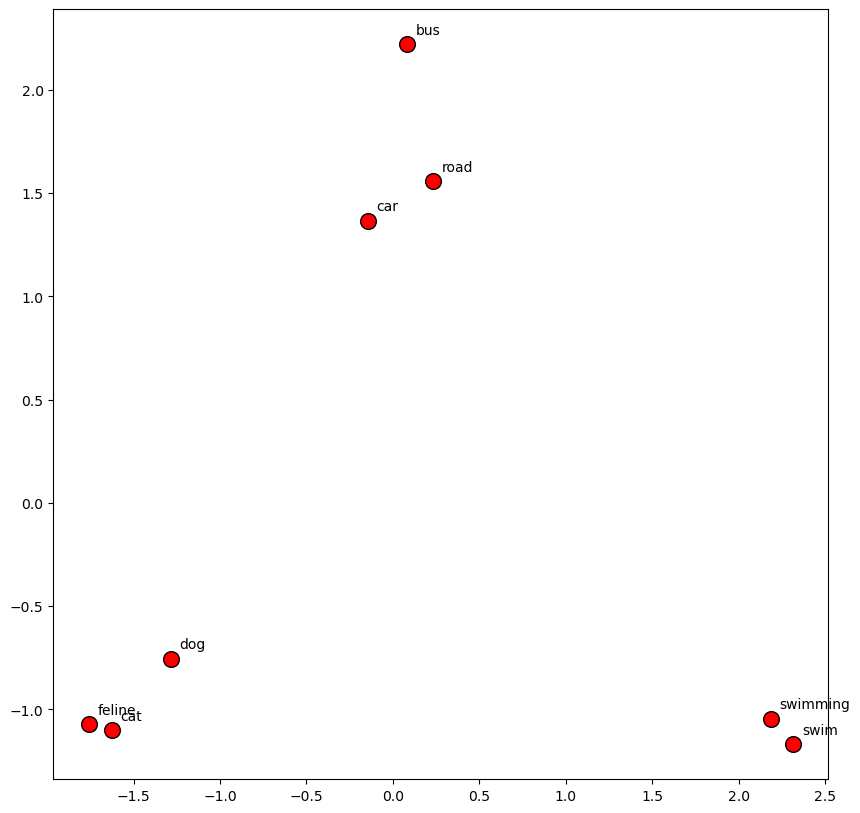

In [373]:
display_pca_scatterplot(word_vectors, ['swim', 'swimming', 'cat', 'dog', 'feline', 'road', 'car', 'bus'])


In [374]:
word_vectors.most_similar(positive=['Italy', 'London'], negative=['Rome'], topn=3)


[('UK', 0.623056948184967),
 ('Britain', 0.6016389727592468),
 ('United_Kingdom', 0.5343458652496338)]

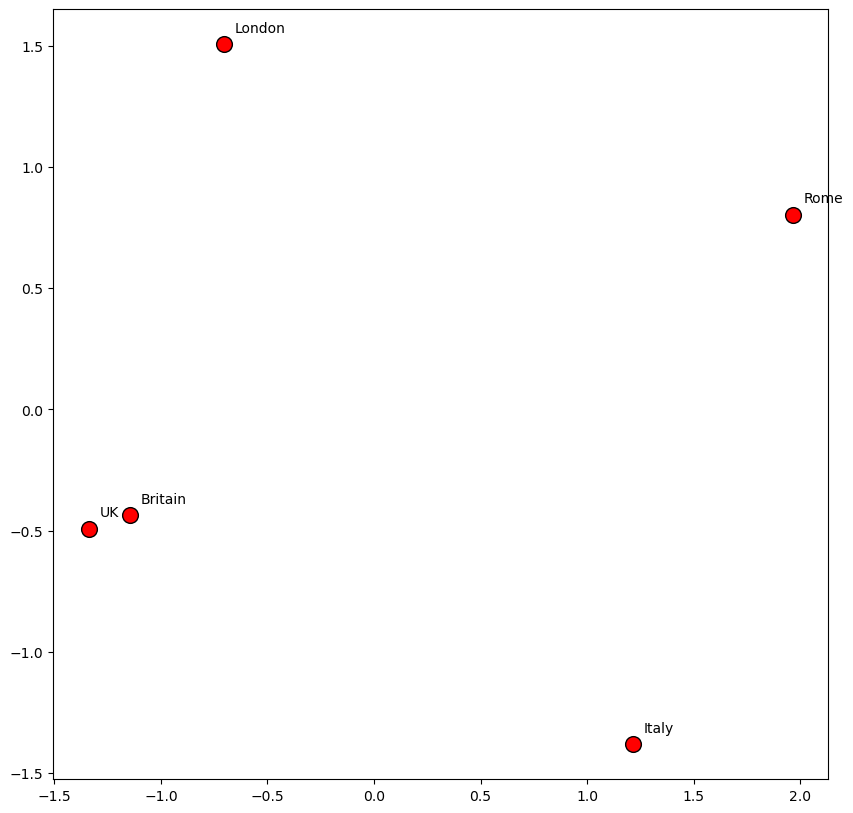

In [375]:
display_pca_scatterplot(word_vectors, ['Rome', 'Italy', 'London', 'Britain', 'UK'])


## 3 Using Pretrained Word Vectors for Classification


In [376]:
word_vectors = KeyedVectors.load_word2vec_format(output, binary=True) # limit=None

print(len(word_vectors))


3000000


### 3.1 validation set


In [377]:
train_df, val_df = train_test_split(training_df, train_size=0.9, random_state=1)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

display(train_df.head())


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_30
0,2017-10-19 01:35:19,UINavigationBar with Large Titles - how to fin...,When using prefersLargeTitles for a UINavigati...,"[ios, uinavigationcontroller, uinavigationbar,...","[uinavigationbar, title, find, height, io]","[uinavigationbar, title, find, height, io, uin...","[find, height, ios]","[uinavigationcontroller, uinavigationbar, nav,...",[ios]
1,2012-02-24 09:29:07,How to Convert a String to a Nullable Type Whi...,I have the below code and I'd need to convert ...,"[c#, asp.net, generics, datetime, nullable]","[convert, string, type, determine, runtime]","[convert, string, type, determine, runtime, co...","[convert, string, type, determine]","[code, need, convert, string, type, specify, t...","[c#, asp.net]"
2,2018-09-05 11:23:00,Scaffold-DbContext (EF Core Tools) throws 'Ins...,"Context\nCurrently I am creating an Extract, T...","[.net-core, ef-database-first, ef-core-2.1, en...","[ef, core, tool, throw, instance, failure, exc...","[ef, core, tool, throw, instance, failure, exc...","[throw, failure, exception]","[context, create, etl, application, write, c, ...",[]
3,2011-07-11 20:48:11,Proxying to another web service with Flask,I want to proxy requests made to my Flask app ...,"[python, proxy, nginx, flask, httplib]","[web, service, flask]","[web, service, flask, want, proxy, request, ma...","[web, service]","[want, proxy, request, app, web, service, run,...",[python]
4,2019-03-17 05:39:24,Upload ZipOutputStream to S3 without saving zi...,I have a requirement to download photos (not i...,"[java, amazon-s3, aws-lambda, aws-java-sdk, zi...","[s3, save, zip, file, disk, s3, java]","[s3, save, zip, file, disk, java, requirement,...","[save, zip, file, disk, aw]","[requirement, download, photo, directory, uplo...",[java]


In [378]:
# Set up training data.

feature = 'title' # on va tester le tokenizer de keras
target = 'top_tags_' + str(NB_TAGS)

X_train = train_df[feature].values
y_train = train_df[target].tolist()

# Set up validation data.
X_val = val_df[feature].values
y_val = val_df[target].tolist()


In [379]:
# encodage target

def target_encoding(y):
    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y)

    return mlb, y_encoded


mlb, y_train_encoded = target_encoding(y_train)
_, y_val_encoded = target_encoding(y_val)

print(y_train_encoded)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### 3.2 tokenization


In [380]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=20000,
                                               filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                                               lower=True)

tokenizer.fit_on_texts(X_train)


In [381]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)

print(X_train_tokens[0])
print([tokenizer.index_word[x] for x in X_train_tokens[0][:3]])


[1816, 6, 682, 2578, 3, 1, 64, 1132, 225, 2, 36]
['uinavigationbar', 'with', 'large']


In [382]:
# Review excerpt reconstructed from integer sequence.
tokenizer.sequences_to_texts([X_train_tokens[0]])[0][:300]


'uinavigationbar with large titles how to find extra height in ios'

In [383]:
# Original review text.
train_df[feature].iloc[0][:300]


'UINavigationBar with Large Titles - how to find extra height in iOS 11'

In [384]:
# Get the number of tokens for each text
num_tokens = [len(tokens) for tokens in tokenizer.texts_to_sequences(X_train)]

# Calculate statistics
mean_tokens = np.mean(num_tokens)
median_tokens = np.median(num_tokens)
mode_tokens = max(set(num_tokens), key=num_tokens.count)
std_tokens = np.std(num_tokens)

# Print statistics
print("Mean number of tokens:", mean_tokens)
print("Median number of tokens:", median_tokens)
print("Mode number of tokens:", mode_tokens)
print("Standard deviation of tokens:", std_tokens)


Mean number of tokens: 9.203574203574204
Median number of tokens: 9.0
Mode number of tokens: 8
Standard deviation of tokens: 3.533756651570345


In [385]:
# Convert list to DataFrame
df_num_tokens = pd.DataFrame(num_tokens, columns=['num_tokens'])

# Use describe() to get summary statistics
summary_stats = df_num_tokens.describe()

print(summary_stats)


        num_tokens
count  3861.000000
mean      9.203574
std       3.534214
min       2.000000
25%       7.000000
50%       9.000000
75%      11.000000
max      29.000000


In [386]:
summary_stats = df_num_tokens.loc[df_num_tokens['num_tokens'] > 11, :].describe()

print(summary_stats)

# OK on va prendre jusqu'à 15 inclus


       num_tokens
count  850.000000
mean    14.378824
std      2.683549
min     12.000000
25%     12.000000
50%     14.000000
75%     15.000000
max     29.000000


### 3.3 Padding


In [387]:
# Pas indispensable ici, mais bientôt utile

MAX_LEN = 15
X_train = keras.preprocessing.sequence.pad_sequences(X_train_tokens, maxlen=MAX_LEN)


In [388]:
print(X_train[0])
print(X_train[1])


[   0    0    0    0 1816    6  682 2578    3    1   64 1132  225    2
   36]
[   0    3    1  114    4   28    1    4  833   40  201    8 2579  108
  506]


In [389]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=MAX_LEN)


### 3.4 embedding matrix


In [390]:
# + 1 to account for padding token.
num_tokens = len(tokenizer.word_index) + 1
print(num_tokens)

# Initialize a matrix of zeroes of size: vocabulary x embedding dimension.
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()


5446


In [391]:
# Quick visual check.
print(embedding_matrix[tokenizer.word_index['good']][:50])


[ 0.04052734  0.0625     -0.01745605  0.07861328  0.03271484 -0.01263428
  0.00964355  0.12353516 -0.02148438  0.15234375 -0.05834961 -0.10644531
  0.02124023  0.13574219 -0.13183594  0.17675781  0.27148438  0.13769531
 -0.17382812 -0.14160156 -0.03076172  0.19628906 -0.03295898  0.125
  0.25390625  0.12695312 -0.15234375  0.03198242  0.01135254 -0.01361084
 -0.12890625  0.01019287  0.23925781 -0.08447266  0.140625    0.13085938
 -0.04516602  0.06494141  0.02539062  0.05615234  0.24609375 -0.20507812
  0.23632812 -0.00860596 -0.02294922  0.05078125  0.10644531 -0.03564453
  0.08740234 -0.05712891]


### 3.5 trainable embedding layer


In [392]:
#
trainable=True

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_LEN,
    trainable=trainable
)


### 3.6 custom metric : jaccard


In [393]:
# Define Jaccard similarity coefficient as a custom metric


def jaccard_similarity(y_pred, y_true):
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, dtype=tf.float32))
    union = tf.reduce_sum(tf.cast(tf.clip_by_value(y_true + y_pred, 0, 1), dtype=tf.float32))
    return intersection / (union + tf.keras.backend.epsilon())


# Compile model with custom metric
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', jaccard_similarity])


### 3.7 compilation d'un premier modele


In [394]:
tf.random.set_seed(0)

model = keras.Sequential()

# This layer will output a sequence of 300-dimension *vectors*, one for each element in the input sequence.
model.add(embedding_layer)

# This layer will calculate an average of those vectors.
model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(150, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(75, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(NB_TAGS, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', jaccard_similarity])


In [395]:
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 15, 300)           1633800   
                                                                 
 global_average_pooling1d_10  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_30 (Dense)            (None, 150)               45150     
                                                                 
 dense_31 (Dense)            (None, 75)                11325     
                                                                 
 dense_32 (Dense)            (None, 30)                2280      
                                                                 
Total params: 1,692,555
Trainable params: 1,692,555
Non-trainable params: 0
___________________________________________

In [396]:
# remettre 20
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=512, validation_data=(X_val, y_val_encoded))


Epoch 1/20


8/8 [==============================] - 1s 70ms/step - loss: 0.6868 - accuracy: 0.0280 - jaccard_similarity: 0.0415 - val_loss: 0.6729 - val_accuracy: 0.0186 - val_jaccard_similarity: 0.0425
Epoch 2/20
8/8 [==============================] - 0s 55ms/step - loss: 0.6465 - accuracy: 0.0306 - jaccard_similarity: 0.0416 - val_loss: 0.5897 - val_accuracy: 0.0186 - val_jaccard_similarity: 0.0422
Epoch 3/20
8/8 [==============================] - 0s 44ms/step - loss: 0.5068 - accuracy: 0.0313 - jaccard_similarity: 0.0411 - val_loss: 0.3638 - val_accuracy: 0.0420 - val_jaccard_similarity: 0.0400
Epoch 4/20
8/8 [==============================] - 0s 43ms/step - loss: 0.2647 - accuracy: 0.0290 - jaccard_similarity: 0.0356 - val_loss: 0.1885 - val_accuracy: 0.0420 - val_jaccard_similarity: 0.0254
Epoch 5/20
8/8 [==============================] - 0s 41ms/step - loss: 0.1902 - accuracy: 0.0313 - jaccard_similarity: 0.0184 - val_loss: 0.2103 - val_accuracy: 0.0559 - val_jaccard_similarity: 0.0127
Epoch 

### 3.8 Visualisation


In [397]:
# add jaccard ?

def plot_train_vs_val_performance(history):
  training_losses = history.history['loss']
  validation_losses = history.history['val_loss']

  training_accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']

  epochs = range(1, len(training_losses) + 1)

  import matplotlib.pyplot as plt
  fig, (ax1, ax2) = plt.subplots(2)
  fig.set_figheight(15)
  fig.set_figwidth(15)
  fig.tight_layout(pad=5.0)

  # Plot training vs. validation loss.
  ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
  ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
  ax1.title.set_text('Training vs. Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # PLot training vs. validation accuracy.
  ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
  ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
  ax2.title.set_text('Training vs. Validation Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.show()

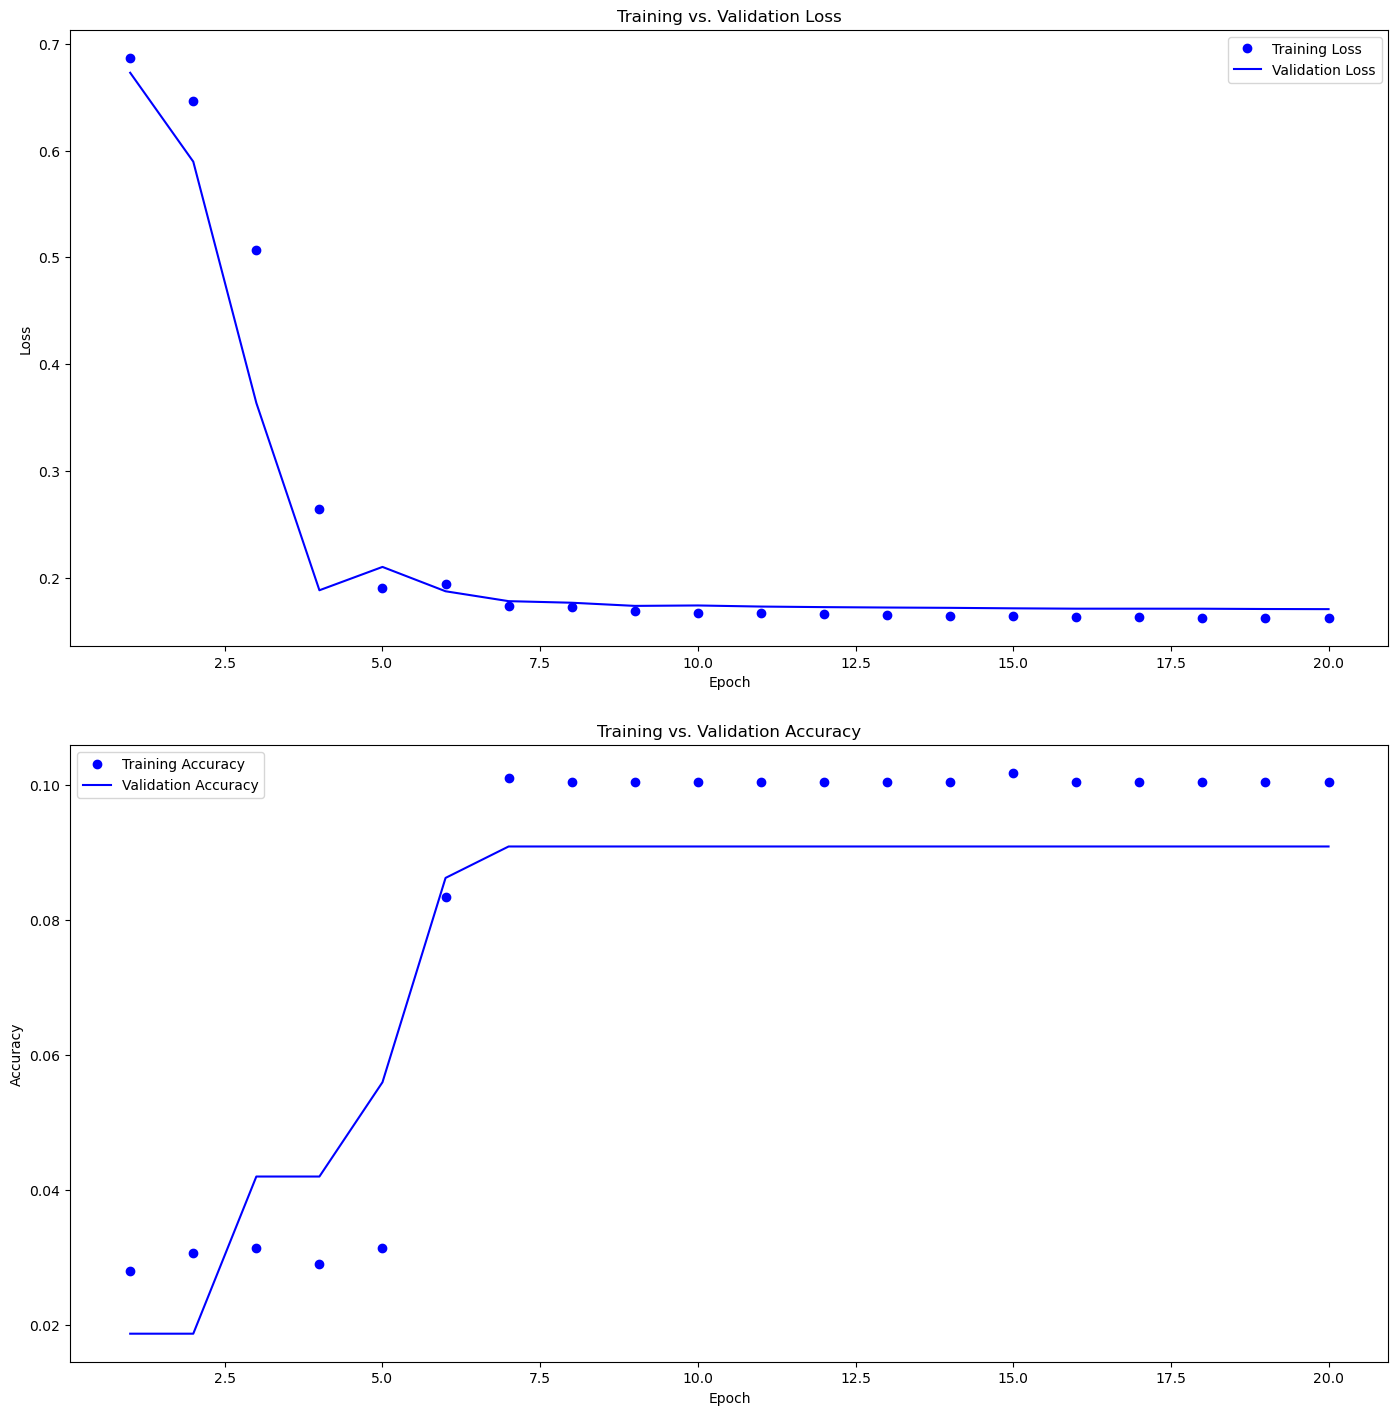

In [398]:
plot_train_vs_val_performance(history)


### 3.9 Entrainement d'un modèle avec early stop


In [399]:
# (pour eviter l'overfitting)

# overfitting apres 15-16 iterations (epochs) (sur title_nltk[::2])
# apres 9 (loss) 11-13 (epochs sur dataset complet (feature=title_nltk)

# si trainable=False (embedding_layer), le plateau (validation) est moins prononcé. 15-16 ?
# apres 10-11 si trainable=True (embedding_layer)

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_LEN,
    trainable=trainable,
    mask_zero=True
)

model = keras.Sequential()

model.add(embedding_layer)

model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(150, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(75, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(NB_TAGS, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', jaccard_similarity])

model.fit(X_train, y_train_encoded, epochs=11, batch_size=512, validation_data=(X_val, y_val_encoded))


Epoch 1/11
8/8 [==============================] - 1s 83ms/step - loss: 0.6843 - accuracy: 0.0287 - jaccard_similarity: 0.0415 - val_loss: 0.6633 - val_accuracy: 0.0186 - val_jaccard_similarity: 0.0426
Epoch 2/11
8/8 [==============================] - 0s 47ms/step - loss: 0.6285 - accuracy: 0.0306 - jaccard_similarity: 0.0415 - val_loss: 0.5469 - val_accuracy: 0.0186 - val_jaccard_similarity: 0.0421
Epoch 3/11
8/8 [==============================] - 0s 47ms/step - loss: 0.4543 - accuracy: 0.0326 - jaccard_similarity: 0.0405 - val_loss: 0.2931 - val_accuracy: 0.0420 - val_jaccard_similarity: 0.0384
Epoch 4/11
8/8 [==============================] - 0s 46ms/step - loss: 0.2268 - accuracy: 0.0290 - jaccard_similarity: 0.0320 - val_loss: 0.1927 - val_accuracy: 0.0420 - val_jaccard_similarity: 0.0193
Epoch 5/11
8/8 [==============================] - 0s 48ms/step - loss: 0.1954 - accuracy: 0.0396 - jaccard_similarity: 0.0166 - val_loss: 0.2118 - val_accuracy: 0.0559 - val_jaccard_similarity: 0.

### 3.10 Evaluation


In [400]:
X_test = test_df[feature].values
y_test = test_df[target].tolist()

_, y_test_encoded = target_encoding(y_test)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN)

model.evaluate(X_test, y_test_encoded)


15/15 [==============================] - 0s 8ms/step - loss: 0.1654 - accuracy: 0.0860 - jaccard_similarity: 0.0359


[0.16540703177452087, 0.08595387637615204, 0.03586170822381973]

In [401]:
# just to be sure

jaccard_similarity(model.predict(X_test), y_test_encoded)

# =0.15003592 sur dataset complet, trainable=False  (11 epochs)
# =0.31942642 sur dataset complet, trainable=True   (11 epochs)
# La différence est nette, du simple au double.

# Les 2 fonctions jaccard donnent des resultas tres proches, mais pas identiques :
# pour x_val (cell precedente) et y_test (ici)


15/15 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.035926387>

### 3.11 prediction


In [402]:
def predict_tags(text, tokenizer=tokenizer, maxlen=MAX_LEN):
    seqs = tokenizer.texts_to_sequences([text])
    print(len(seqs))
    print(seqs)
    for seq in seqs:
        print(seq)
        print([tokenizer.index_word[x] for x in seq])

    seqs = keras.preprocessing.sequence.pad_sequences(seqs, maxlen=maxlen)

    return model.predict(seqs)


tags = predict_tags(text="The best the best sea food apple pie")


1
[[5, 329, 5, 329, 908, 3358]]
[5, 329, 5, 329, 908, 3358]
['the', 'best', 'the', 'best', 'apple', 'pie']
1/1 [==============================] - 0s 18ms/step


In [403]:
pprint(tags)
print(tags.shape)


array([[0.0469656 , 0.10178176, 0.02574904, 0.03363901, 0.02402995,
        0.02539001, 0.10524232, 0.06447308, 0.04045862, 0.06524053,
        0.07817762, 0.03403362, 0.13792941, 0.13685654, 0.04742884,
        0.03463099, 0.03503163, 0.02495185, 0.05473033, 0.03840323,
        0.02720111, 0.05353147, 0.1525076 , 0.03019112, 0.03478427,
        0.04171497, 0.03623468, 0.03234073, 0.02621983, 0.03400874]],
      dtype=float32)
(1, 30)


In [404]:
def jaccard_topics(topic1, topic2):
    set1 = set(topic1)
    set2 = set(topic2)

    if len(set1.union(set2)):
        return len(set1.intersection(set2)) / len(set1.union(set2))

    else: # union nulle = 0 prediction, mais rien à prédire non plus
        return 1


In [405]:
# OK reste juste à récup / associer les tags equivalents (targets)


# Step 1: Make predictions with the model
predictions = model.predict(X_test[:100])
print('\n')

# Step 2: Get the indices of the top n most probable tags
n = 5  # Number of top tags to return
top_n_indices = np.argsort(predictions, axis=1)[:, -n:]

# Step 3: Get the associated tags
associated_tags = []
for indices in top_n_indices:
    tags = [all_tags[i] for i in indices]
    associated_tags.append(tags)

# Print associated tags for each input text
score_total = 0
for i, tags in enumerate(associated_tags):
    print(i)
    print(f"all tags: {test_df['all_tags'][i]}")
    print(f'real tags: {y_test[i]}')
    print(f"Top {n} tags: {tags}")
    jacc = jaccard_topics(tags, y_test[i])
    print(f'jaccard: {jacc}')
    score_total += jacc
    print('\n')

print(f'score_total = {score_total}')

# probleme
# les scores calculés sur les distributions de probabilités prédites semblaient prometteurs,
# mais en pratique les prédictions sont catastrophiques
# (1 seule prédiction correcte (index 79) sur 100 tests...)
# On avait un comportement similaire avec la méthode predict_poba des modeles classiques

# Il faudrait peut-etre une architecture différente, avec une derniere layer à 5 outputs
# (nb de tags prédits)


4/4 [==============================] - 0s 3ms/step


0
all tags: ['php', 'laravel-5', 'oauth', 'permissions', 'laravel-passport']
real tags: ['php']
Top 5 tags: ['flask', 'compiler-errors', 'large-language-model', 'langchain', 'eclipse']
jaccard: 0.0


1
all tags: ['python', 'selenium', 'browser', 'selenium-webdriver', 'incognito-mode']
real tags: ['python']
Top 5 tags: ['flask', 'compiler-errors', 'langchain', 'large-language-model', 'eclipse']
jaccard: 0.0


2
all tags: ['spring', 'mongodb', 'spring-data', 'spring-data-mongodb', 'hibernate-ogm']
real tags: ['spring']
Top 5 tags: ['flask', 'compiler-errors', 'large-language-model', 'langchain', 'eclipse']
jaccard: 0.0


3
all tags: ['c#', '.net', 'mapping', 'automapper', 'automapper-2']
real tags: ['c#', '.net']
Top 5 tags: ['flask', 'compiler-errors', 'large-language-model', 'langchain', 'eclipse']
jaccard: 0.0


4
all tags: ['python', 'multidimensional-array', 'deep-learning', 'pytorch', 'tensor']
real tags: ['python']
Top 5 tags: [

### 3.12 word2vec + svm


In [406]:
def jaccard_score(y_true, y_pred): # pour comparer 2 df ou 2 matrices de mm shape[0]
    jacc = 0
    for i in range(0, len(y_pred)):
        jacc += jaccard_topics(y_true[i], y_pred[i])
    jacc_moyen = jacc / len(y_pred)

    return jacc_moyen


In [407]:
# Create an SGDClassifier with default parameters
sgd_clf = SGDClassifier(random_state=42, loss='log_loss')  # for logistic regression

# Create a MultiOutputClassifier with the SGD classifier
multi_output_classifier = MultiOutputClassifier(sgd_clf)

# Fit the MultiOutputClassifier to your training data
multi_output_classifier.fit(X_train, y_train_encoded)
print('training fini', '\n')

predictions_train = multi_output_classifier.predict(X_train)
predictions_test = multi_output_classifier.predict(X_test)

print('SCORES TAGS (TOKENS)', '\n')

predicted_tags_train = mlb.inverse_transform(predictions_train)
predicted_tags_test = mlb.inverse_transform(predictions_test)

# Evaluate the model on training data using jaccard similarity
scorer = jaccard_score
score_train = scorer(predicted_tags_train, y_train)
print("Jaccard similarity (training set): ", score_train)
print('\n')

# Evaluate the model on test data
score_test = scorer(predicted_tags_test, y_test)
print("Jaccard similarity (testing set): ", score_test)

# décevant, le meme modele faisait mieux a partir d'un bag of word
# (et sur un nb > de tags possivbles)


training fini 

SCORES TAGS (TOKENS) 

Jaccard similarity (training set):  0.10889789223122547


Jaccard similarity (testing set):  0.10404312668463611


## 4 BERT


### Checkpoint


In [425]:
training_df, test_df = create_top_n_tags_feature(data=raw_data, n=NB_TAGS, slice=sample, df_freq=df_freq)


(47665, 9) 



### 4.1 Premier test d'un modele bert


In [426]:
# Pour le fun

qa = pipeline("question-answering")

context=test_df['body'][1]

question = "What topics is this about ?"

reponse = qa(question=question, context=context)


No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForQuestionAnswering.

All the weights of TFDistilBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [427]:
print(context)


I can not seem to find any documentation on how to make Selenium open the browser in incognito mode. 
Do I have to setup a custom profile in the browser or?



In [428]:
print(reponse)

# Pas mal, mais on n'est plus vraiment dans le supervisé !


{'score': 0.12743693590164185, 'start': 44, 'end': 99, 'answer': 'how to make Selenium open the browser in incognito mode'}


### 4.2 BERT HuggingFace


In [429]:
# import tensorflow_hub as hub
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
from transformers import TFAutoModel

os.environ["TF_KERAS"]='1'


In [430]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda()) # False, no gpu support


2.12.0
Num GPUs Available:  0
False


In [431]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    num_batches = (len(sentences) + batch_size - 1) // batch_size
    for step in range(num_batches):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states # ??
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot


In [432]:
max_length = 15
batch_size = 10
model_type = 'bert-base-uncased'

model = TFAutoModel.from_pretrained(model_type)

sentences = training_df[feature].tolist()

print(len(sentences))
print(training_df.shape)

sentences_test = test_df[feature].tolist()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

4290
(4290, 9)


In [433]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

# long !


1/1 [==============================] - 0s 369ms/step
temps traitement :  287.0


In [434]:
features_bert_test, _ = feature_BERT_fct(model, model_type, sentences_test,
                                                         max_length, batch_size, mode='HF')


1/1 [==============================] - 3s 3s/step
temps traitement :  30.0


In [435]:
y_train = training_df[target].tolist()

mlb, y_train_encoded = target_encoding(y_train)


In [436]:
features_bert.shape


(4290, 768)

In [437]:
y_train_encoded.shape


(4290, 30)

In [438]:
# Create an SGDClassifier with default parameters
sgd_clf = SGDClassifier(random_state=42, loss='log_loss')  # for logistic regression

# Create a MultiOutputClassifier with the SGD classifier
multi_output_classifier = MultiOutputClassifier(sgd_clf)

# Fit the MultiOutputClassifier to your training data
multi_output_classifier.fit(features_bert, y_train_encoded)
print('training fini', '\n')

predictions_train = multi_output_classifier.predict(features_bert)
predictions_test = multi_output_classifier.predict(features_bert_test) # feature_bertiser X_test

print('SCORES TAGS (TOKENS)', '\n')

predicted_tags_train = mlb.inverse_transform(predictions_train)
predicted_tags_test = mlb.inverse_transform(predictions_test)

# Evaluate the model on training data using jaccard similarity
scorer = jaccard_score
print(len(predicted_tags_train))
print(len(y_train))
score_train = scorer(predicted_tags_train, y_train)
print("Jaccard similarity (training set): ", score_train)
print('\n')

# Evaluate the model on test data
print(len(predicted_tags_test))
print(len(y_test))
score_test = scorer(predicted_tags_test, y_test)
print("Jaccard similarity (testing set): ", score_test)

# décevant, le meme modele faisait mieux a partir d'un bag of word
# (et sur un nb > de tags possibles)

# Le score semble fou pour un fit sur un sample ::10
# Ca donne envie de verifier les predictions.


training fini 

SCORES TAGS (TOKENS) 

4290
4290
Jaccard similarity (training set):  0.589393939393939


477
477
Jaccard similarity (testing set):  0.30548567435359875


In [441]:
for i in range(0, 31):
    print(y_test[i])
    print(predicted_tags_test[i], '\n')

# Assez bluffant en effet, dommage encore bcp de reponses vides.
# (nb de tags trop petit ?)


['php']
('c++', 'node.js', 'php') 

['python']
() 

['spring']
('java', 'spring') 

['c#', '.net']
() 

['python']
() 

['php']
() 

['linux']
('linux',) 

[]
('sql',) 

['node.js']
() 

['java']
() 

['ios', 'objective-c', 'xcode']
('ios', 'xcode') 

['javascript', 'html']
('html', 'javascript') 

['c++']
('c++',) 

['javascript', 'jquery']
('arrays',) 

['c#', 'asp.net-mvc', 'json']
('typescript',) 

['python']
('pandas', 'python') 

[]
('python',) 

['typescript']
('java',) 

[]
('xcode',) 

['java']
('java',) 

['c#', '.net']
('java',) 

['java', 'spring']
('node.js',) 

[]
() 

['java', 'spring']
() 

[]
('javascript',) 

[]
('c', 'java') 

[]
('javascript',) 

['python']
() 

['python']
('python', 'python-3.x') 

[]
() 

['android']
('android',) 



## Ressources


In [439]:
# Word2vec
# https://colab.research.google.com/github/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_word_vectors.ipynb#scrollTo=SBQlbyiVY3WJ


